In [13]:
import jax
import jax.numpy as jnp
import optax
import flax.nnx as nnx
from flax.training import train_state
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import jax
import jax.numpy as jnp
import flax.nnx as nnx
from jax import random
from flax import serialization
import json
import optax
import numpy as np
from sklearn.utils.estimator_checks import check_is_fitted
from sklearn.base import BaseEstimator, _fit_context
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from tqdm.notebook import tqdm # progress bar
from sklearn.preprocessing import StandardScaler
import logging
from tqdm import trange
from matplotlib.pyplot import plot
import joblib
import msgpack
import pathlib

In [14]:
features = np.loadtxt("../Data/Training_data/meshsize_features3.txt")[:,2:]#.reshape(-1,1)
labels = np.loadtxt("../Data/Training_data/meshsize_labels3.txt")[:,[0]]

print(features.shape)

(1645878, 8)


In [15]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Standardize input features (only fit on training data!)
scaler = StandardScaler()


X_train = scaler.fit_transform(X_train)
joblib.dump(scaler, 'scaler.pkl')
X_test = scaler.transform(X_test)

X_grid, _, y_grid, _ = train_test_split(X_train, y_train, train_size=0.4, random_state=42) # Only using 40% of the data for gridsearching

# Convert to JAX arrays
X_train = jnp.array(X_train, dtype=jnp.float32)
y_train = jnp.array(y_train, dtype=jnp.float32)

X_test = jnp.array(X_test, dtype=jnp.float32)
y_test = jnp.array(y_test, dtype=jnp.float32)

# X_grid = jnp.array(X_grid, dtype=jnp.float32)
# y_grid = jnp.array(y_grid, dtype=jnp.float32)

In [16]:
X_train.shape

(1316702, 8)

In [17]:
# Your MLP model
class MLP(nnx.Module):
    def __init__(self, din, dout, rngs: nnx.Rngs):
        self.linear1 = nnx.Linear(din, 64, rngs=rngs)
        self.linear2 = nnx.Linear(64, 128, rngs=rngs)
        self.linear3 = nnx.Linear(128, 128, rngs=rngs)
        self.linear4 = nnx.Linear(128, 64, rngs=rngs)
        self.linear5 = nnx.Linear(64, dout, rngs=rngs)

    def __call__(self, x):
        x = nnx.relu(self.linear1(x))
        x = nnx.relu(self.linear2(x))
        x = nnx.relu(self.linear3(x))
        x = nnx.relu(self.linear4(x))
        return self.linear5(x)

# Init
model = MLP(X_train.shape[1], 1, rngs=nnx.Rngs(0))
optimizer = nnx.Optimizer(model, optax.adam(1e-3))

# Train step
@nnx.jit
def train_step(model, optimizer, x, y):
    def loss_fn(model):
        preds = model(x)
        return jnp.mean((preds - y) ** 2)

    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)
    return loss

r2_test_history = []
# Training loop
batch_size = 100000  # Choose a smaller batch size!

for epoch in trange(1000, desc="Training"):
    # Shuffle the data at the start of each epoch
    perm = jax.random.permutation(jax.random.PRNGKey(epoch), len(X_train))
    X_train_shuffled = X_train[perm]
    y_train_shuffled = y_train[perm]

    # Mini-batch training
    for i in range(0, len(X_train), batch_size):
        x_batch = X_train_shuffled[i:i+batch_size]
        y_batch = y_train_shuffled[i:i+batch_size]
        loss = train_step(model, optimizer, x_batch, y_batch)
        loss.block_until_ready()  # <- Add this!

    # Evaluate on the whole test set
    y_pred_test = optimizer.model(X_test)
    r2_test = r2_score(y_test, np.array(y_pred_test))
    r2_test_history.append(r2_test)



Training: 100%|██████████| 1000/1000 [04:02<00:00,  4.13it/s]


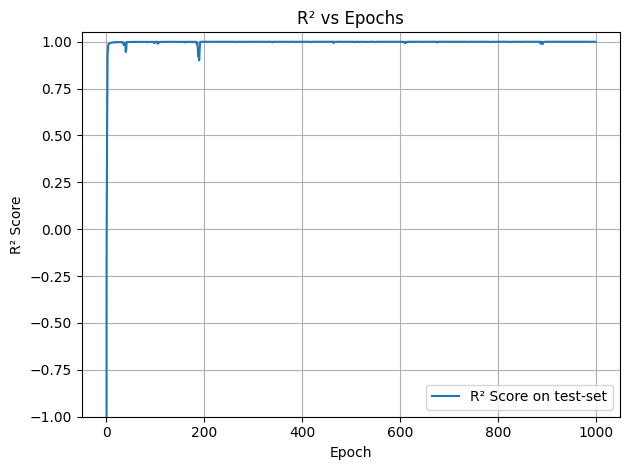

In [18]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

plt.figure()
epochs = list(range(len(r2_test_history)))  # assuming both lists are the same length

# Plotting both curves

plt.plot(epochs, r2_test_history, label="R² Score on test-set")

# Styling
plt.xlabel("Epoch")
plt.ylabel("R² Score")
plt.title("R² vs Epochs")
plt.ylim(-1, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
plot_r2_progress(r2_history)

NameError: name 'plot_r2_progress' is not defined

In [19]:
# Predict
y_pred = optimizer.model(X_test)


In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error
import numpy as np

# y_true: your ground truth values
# y_pred: your model's predictions

def print_regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    max_err = max_error(y_true, y_pred)

    print(f"📈 Regression Evaluation Metrics")
    print(f"--------------------------------")
    print(f"R² Score         : {r2:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Max Error        : {max_err:.4f}")

In [21]:
print_regression_metrics(y_test, y_pred)

📈 Regression Evaluation Metrics
--------------------------------
R² Score         : 0.9997
Mean Absolute Error (MAE): 0.0124
Mean Squared Error (MSE): 0.0003
Root Mean Squared Error (RMSE): 0.0162
Max Error        : 2.8940


In [35]:
test_features = np.loadtxt("../Data/Training_data/testcloud_feat_1mm.txt")[:,2:]#.reshape(-1,1)
test_labels = np.loadtxt("../Data/Training_data/testcloud_lab_1mm.txt")[:,[0]]

test_features2 = np.loadtxt("../Data/Training_data/testcloud_feat_05.txt")[:,2:]#.reshape(-1,1)
test_labels2 = np.loadtxt("../Data/Training_data/testcloud_lab_05.txt")[:,[0]]


test_features3 = np.loadtxt("../Data/Training_data/testcloud_feat_2mm.txt")[:,2:]#.reshape(-1,1)
test_labels3 = np.loadtxt("../Data/Training_data/testcloud_lab_2mm.txt")[:,[0]]


mesh = np.hstack((np.full(len(test_features),1), np.full(len(test_features2),0.5), np.full(len(test_features3),2)))

test_features = np.vstack((test_features,test_features2,test_features3))
test_labels = np.vstack((test_labels,test_labels2,test_labels3))

scaler_reload = joblib.load('scaler.pkl')
X_test2 = scaler_reload.transform(test_features)

X_test2 = jnp.array(X_test2, dtype=jnp.float32)
y_test2 = jnp.array(test_labels, dtype=jnp.float32)


hole_features = np.loadtxt("../Data/Training_data/Gear_w_holes_features.txt")[:,2:]#.reshape(-1,1)
X_test_holes = scaler_reload.transform(hole_features)




In [36]:
# Predict
y_pred2 = optimizer.model(X_test2)
y_pred_holes =optimizer.model(X_test_holes)

Standard deviation for 0.5mm mesh: 0.009420443
Standard deviation for 1mm mesh: 0.016259491
Standard deviation for 2mm mesh: 0.013954265
📈 Regression Evaluation Metrics
--------------------------------
R² Score         : 0.9954
Mean Absolute Error (MAE): 0.0559
Mean Squared Error (MSE): 0.0036
Root Mean Squared Error (RMSE): 0.0603
Max Error        : 0.2799


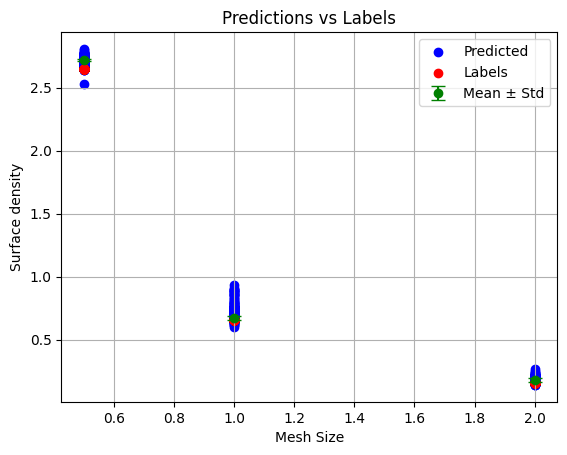

In [32]:
highest = np.max(y_pred2)
mean = np.mean(y_pred2)
#print(test_labels)
#print(mean)
#print(y_pred2)

pred_05 = y_pred2[np.where(mesh == 0.5)]
pred_1 = y_pred2[np.where(mesh == 1)]
pred_2 = y_pred2[np.where(mesh == 2)]

std_05 = np.std(pred_05)
std_1 = np.std(pred_1)
std_2 = np.std(pred_2)
stds = [std_05, std_1, std_2]

print("Standard deviation for 0.5mm mesh:", std_05)
print("Standard deviation for 1mm mesh:", std_1)
print("Standard deviation for 2mm mesh:", std_2)

mean_05 = np.mean(pred_05)
mean_1 = np.mean(pred_1)
mean_2 = np.mean(pred_2)

mesh_short = [0.5, 1, 2]
means = [mean_05, mean_1, mean_2]

print_regression_metrics(y_test2, y_pred2)
#r2 = r2_score(y_test2,y_pred2)
#print(r2)

plt.scatter(mesh, y_pred2, color='blue', label='Predicted')
plt.scatter(mesh, y_test2, color='red', label='Labels')
plt.errorbar(mesh_short, means, yerr=stds, fmt='o', color='green', capsize=5, label='Mean ± Std')
plt.xlabel("Mesh Size")
plt.ylabel("Surface density")
plt.title("Predictions vs Labels")
plt.legend()
plt.grid(True)
plt.show()

## Different mesh sizes


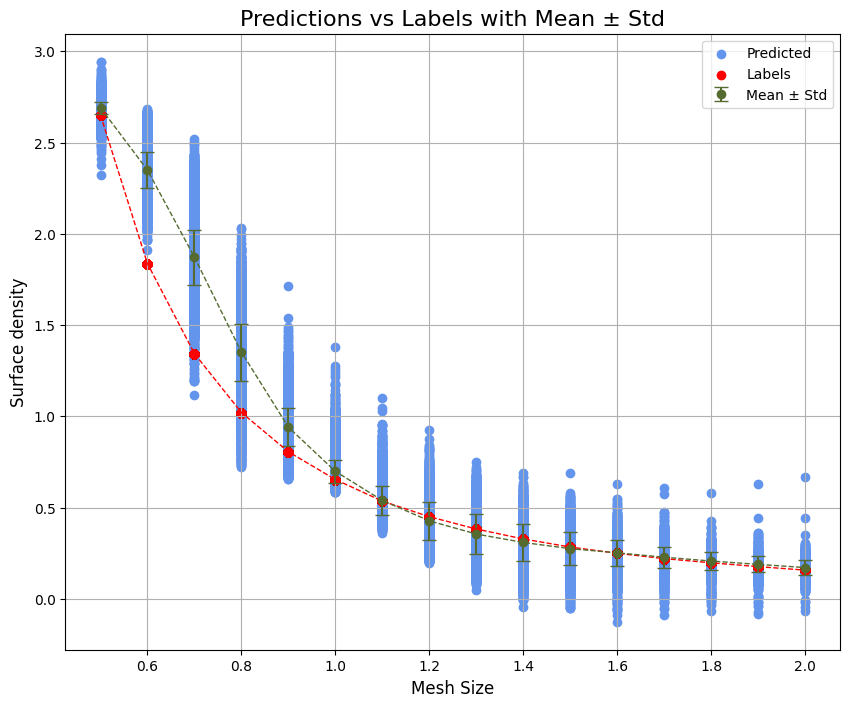

In [40]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import os
save_path = os.path.join(os.getcwd(), "predict_vs_label_first.png")

# Load your data
test_features = np.loadtxt("../Data/Training_data/Chain_whee_features.txt")[:, 2:]
test_labels = np.loadtxt("../Data/Training_data/Chain_whee_labels.txt")[:, [0]]
mesh_size = np.loadtxt("../Data/Training_data/Chain_whee_labels.txt")[:, [1]]

# Scaling
scaler_reload = joblib.load('scaler.pkl')
X_test_intevals = scaler_reload.transform(test_features)

# Convert to JAX arrays
X_test_intevals = jnp.array(X_test_intevals, dtype=jnp.float32)
y_test_intevals = jnp.array(test_labels, dtype=jnp.float32)

# Model prediction
y_pred_intevals = optimizer.model(X_test_intevals)

# Convert mesh size and predictions to numpy for easier handling
mesh_size_np = np.squeeze(np.array(mesh_size))
y_pred_np = np.squeeze(np.array(y_pred_intevals))

# Compute mean and std for each unique mesh size
unique_mesh_sizes = np.unique(mesh_size_np)
means = []
stds = []

for mesh in unique_mesh_sizes:
    mask = mesh_size_np == mesh
    mesh_preds = y_pred_np[mask]
    mean_pred = np.mean(mesh_preds)
    std_pred = np.std(mesh_preds)
    means.append(mean_pred)
    stds.append(std_pred)

# Plot

plt.figure(figsize=(10, 8))

# Scatter plot for predictions and labels
plt.scatter(mesh_size_np, y_pred_np, color='cornflowerblue', label='Predicted')
plt.scatter(mesh_size_np, np.squeeze(np.array(y_test_intevals)), color='red', label='Labels')

# Error bars for mean ± std
plt.errorbar(unique_mesh_sizes, means, yerr=stds, fmt='o', color='darkolivegreen', capsize=5, label='Mean ± Std')

# Line connecting the label points (labels)
# Sort the data to ensure lines connect in mesh_size order
sort_idx_labels = np.argsort(mesh_size_np)
plt.plot(mesh_size_np[sort_idx_labels],
         np.squeeze(np.array(y_test_intevals))[sort_idx_labels],
         color='red', linestyle='--', linewidth=1)

# Line connecting the mean predictions
sort_idx_means = np.argsort(unique_mesh_sizes)
plt.plot(unique_mesh_sizes[sort_idx_means],
         np.array(means)[sort_idx_means],
         color='darkolivegreen', linestyle='--', linewidth=1)

# Labels and title
plt.xlabel("Mesh Size", fontsize=12)
plt.ylabel("Surface density", fontsize=12)
plt.title("Predictions vs Labels with Mean ± Std",fontsize=16)
plt.legend()
plt.grid(True)
# plt.savefig(save_path, dpi=2000, bbox_inches='tight')
plt.show()

## Visualization on parts


In [33]:
cloud_05 = np.loadtxt("../../Leihui Code/dataset/SelfGeneratedClouds/Chain_wheel_05.xyz")
cloud_1 = np.loadtxt("../../Leihui Code/dataset/SelfGeneratedClouds/Chain_wheel_1mm.xyz")
cloud_2 = np.loadtxt("../../Leihui Code/dataset/SelfGeneratedClouds/Chain_wheel_2mm.xyz")

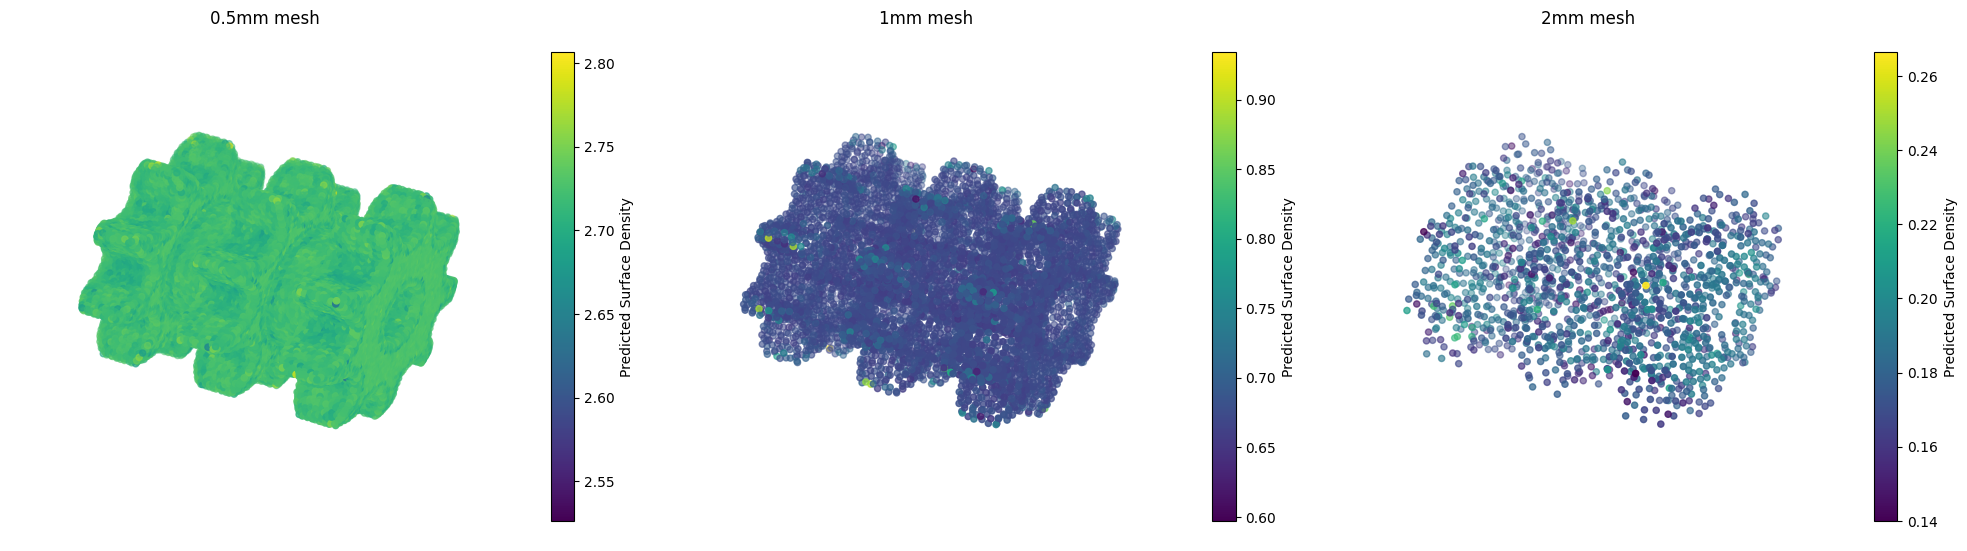

In [34]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

# Prepare point clouds and predictions
clouds = [cloud_05, cloud_1, cloud_2]
preds = [pred_05, pred_1, pred_2]
titles = ["0.5mm mesh", "1mm mesh", "2mm mesh"]

fig = plt.figure(figsize=(20, 7))
for i, (cloud, pred, title) in enumerate(zip(clouds, preds, titles)):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    sc = ax.scatter(cloud[:, 0], cloud[:, 1], cloud[:, 2], c=pred.flatten(), cmap='viridis')
    ax.set_title(title)
    ax.set_axis_off()
    fig.colorbar(sc, ax=ax, shrink=0.7, label='Predicted Surface Density')

plt.tight_layout()
plt.show()

In [38]:
%matplotlib Widget

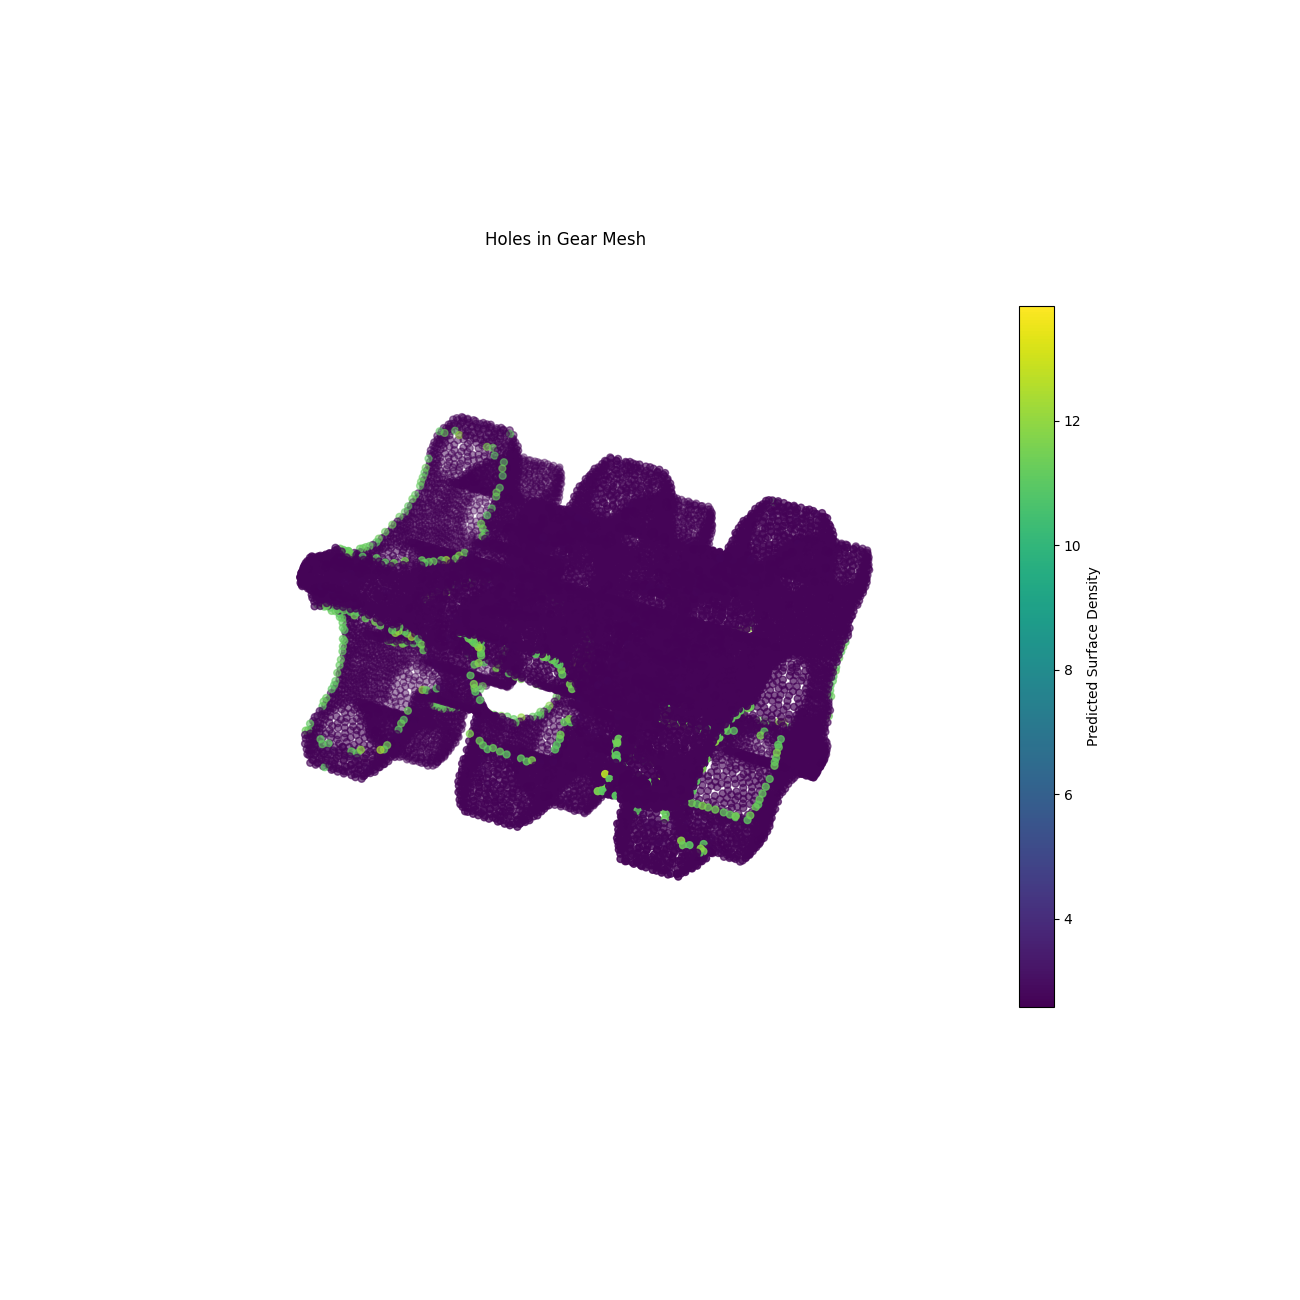

In [51]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

# Load point cloud
cloud = np.loadtxt("../Data/Training_data/Gear_w_holes.txt")

# Your prediction
pred = y_pred_holes.flatten()

# Transform predictions
pred_transformed = np.where(pred > 2.75, pred * 4, pred)

title = "Holes in Gear Mesh"

fig = plt.figure(figsize=(13, 13))
ax = fig.add_subplot(111, projection='3d')

# Plot with transformed predictions
sc = ax.scatter(cloud[:, 0], cloud[:, 1], cloud[:, 2],
                 c=pred_transformed, cmap='viridis', s=25)

ax.set_title(title)
ax.set_axis_off()

fig.colorbar(sc, ax=ax, shrink=0.7, label='Predicted Surface Density')

plt.show()
